In [9]:
#### Preamble ####
# Purpose: Explore some potential relationships among the variables of the dataset
# Author: Jiazhou(Justin) Bi
# Date: 16 Nov 2024
# Contact: justin.bi@mail.utoronto.ca
# License: None
# Pre-requisites: see requirements.txt
# Any other information needed? None

# Loading the Dataset and Libraries

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df_1m = pd.read_parquet('../data/02-analysis_data/cleaned_data_1m.parquet')
df_1h = pd.read_parquet('../data/02-analysis_data/cleaned_data_1h.parquet')
df_1d = pd.read_parquet('../data/02-analysis_data/cleaned_data_1d.parquet')
df_1m.head()

,open,high,low,close,volume,index,was_missing,direction_t-1,direction_t+1
0,4261.48,4261.48,4261.48,4261.48,1.775183,2017-08-17 04:00:00,0,0,0
1,4261.48,4261.48,4261.48,4261.48,0.000000,2017-08-17 04:01:00,0,0,1
2,4280.56,4280.56,4280.56,4280.56,0.261074,2017-08-17 04:02:00,0,1,-1
3,4261.48,4261.48,4261.48,4261.48,0.012008,2017-08-17 04:03:00,0,-1,0
4,4261.48,4261.48,4261.48,4261.48,0.140796,2017-08-17 04:04:00,0,0,0


# Descriptive Statistics

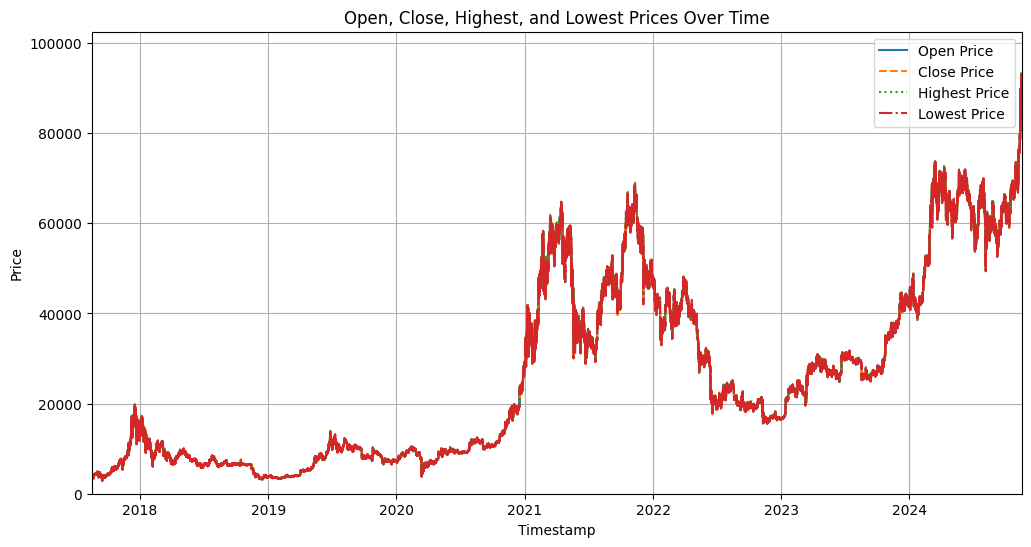

In [11]:
df_1m = pd.read_parquet('../data/02-analysis_data/cleaned_data_1m.parquet')
df_1m['index'] = pd.to_datetime(df_1m['index'])
df_1m.set_index('index', inplace=True)


plt.figure(figsize=(12, 6))
plt.plot(df_1m.index, df_1m['open'], label='Open Price', linewidth=1.5)
plt.plot(df_1m.index, df_1m['close'], label='Close Price', linewidth=1.5, linestyle='--')
plt.plot(df_1m.index, df_1m['high'], label='Highest Price', linewidth=1.5, linestyle=':')
plt.plot(df_1m.index, df_1m['low'], label='Lowest Price', linewidth=1.5, linestyle='-.')


plt.title('Open, Close, Highest, and Lowest Prices Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.xlim(df_1m.index.min(), df_1m.index.max())  # X-axis range
plt.ylim(0, max(df_1m['open'].max(), df_1m['close'].max()) * 1.1)  # Y-axis range with buffer
plt.grid(True)
plt.legend()
plt.savefig('../other/graphs/all_price_plot_1m.png', dpi=300, bbox_inches='tight')
plt.show()

Correlation Test

In [12]:
# Select the relevant columns
columns = ['open', 'high', 'low', 'close']
correlation_matrix = df_1m[columns].corr()

# Print the correlation matrix
print(correlation_matrix)

           open      high       low     close
open   1.000000  0.999999  0.999999  0.999999
high   0.999999  1.000000  0.999998  0.999999
low    0.999999  0.999998  1.000000  0.999999
close  0.999999  0.999999  0.999999  1.000000


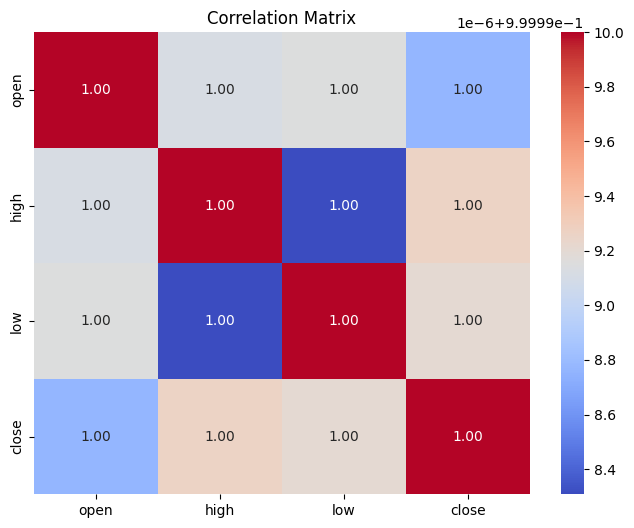

In [13]:
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig('../other/graphs/all_price_correlation_1m.png', dpi=300, bbox_inches='tight')
plt.show()

Similar patterns can be expected for the 1-hour and 1-day datasets, as the only difference of them is the granularity. 

As a result, we will engineer a new column for each of the four features mentioned above to indicate their lagged differences.

In [14]:
# Compute lagged differences
df_1m['open_diff'] = df_1m['open'].diff()
df_1m['high_diff'] = df_1m['high'].diff()
df_1m['low_diff'] = df_1m['low'].diff()
df_1m['close_diff'] = df_1m['close'].diff()
# Drop the first row with no difference
df_1m = df_1m.dropna()
df_1m.head()

,open,high,low,close,volume,was_missing,direction_t-1,direction_t+1,open_diff,high_diff,low_diff,close_diff
index,,,,,,,,,,,,
2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,0,0,1,0.00,0.00,0.00,0.00
2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,0,1,-1,19.08,19.08,19.08,19.08
2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,0,-1,0,-19.08,-19.08,-19.08,-19.08
2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,0,0,0,0.00,0.00,0.00,0.00
2017-08-17 04:05:00,4261.48,4261.48,4261.48,4261.48,0.000000,0,0,0,0.00,0.00,0.00,0.00


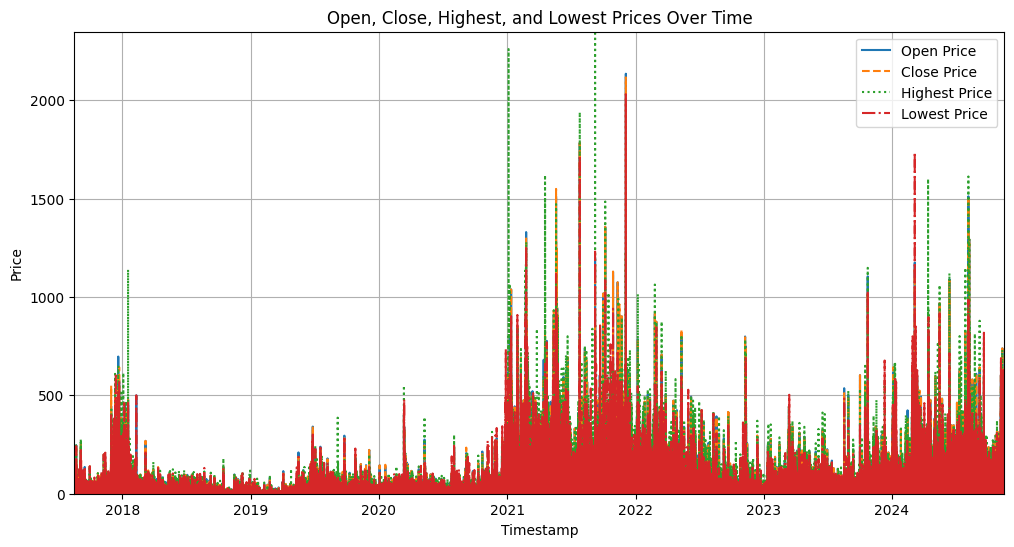

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(df_1m.index, df_1m['open_diff'], label='Open Price', linewidth=1.5)
plt.plot(df_1m.index, df_1m['close_diff'], label='Close Price', linewidth=1.5, linestyle='--')
plt.plot(df_1m.index, df_1m['high_diff'], label='Highest Price', linewidth=1.5, linestyle=':')
plt.plot(df_1m.index, df_1m['low_diff'], label='Lowest Price', linewidth=1.5, linestyle='-.')


plt.title('Open, Close, Highest, and Lowest Prices Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.xlim(df_1m.index.min(), df_1m.index.max())  # X-axis range
plt.ylim(0, max(df_1m['open_diff'].max(), df_1m['close_diff'].max()) * 1.1)  # Y-axis range with buffer
plt.grid(True)
plt.legend()
plt.savefig('../other/graphs/all_price_diff_plot_1m.png', dpi=300, bbox_inches='tight')
plt.show()

            open_diff  high_diff  low_diff  close_diff
open_diff    1.000000   0.499765  0.514664    0.014986
high_diff    0.499765   1.000000  0.525970    0.599316
low_diff     0.514664   0.525970  1.000000    0.592994
close_diff   0.014986   0.599316  0.592994    1.000000


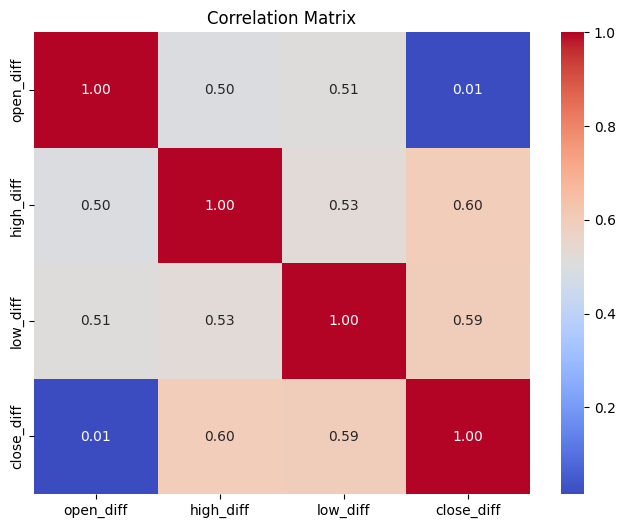

In [16]:
# Select the relevant columns
columns = ['open_diff', 'high_diff', 'low_diff', 'close_diff']
correlation_matrix = df_1m[columns].corr()

# Print the correlation matrix
print(correlation_matrix)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig('../other/graphs/all_price_diff_correlation_1m.png', dpi=300, bbox_inches='tight')
plt.show()

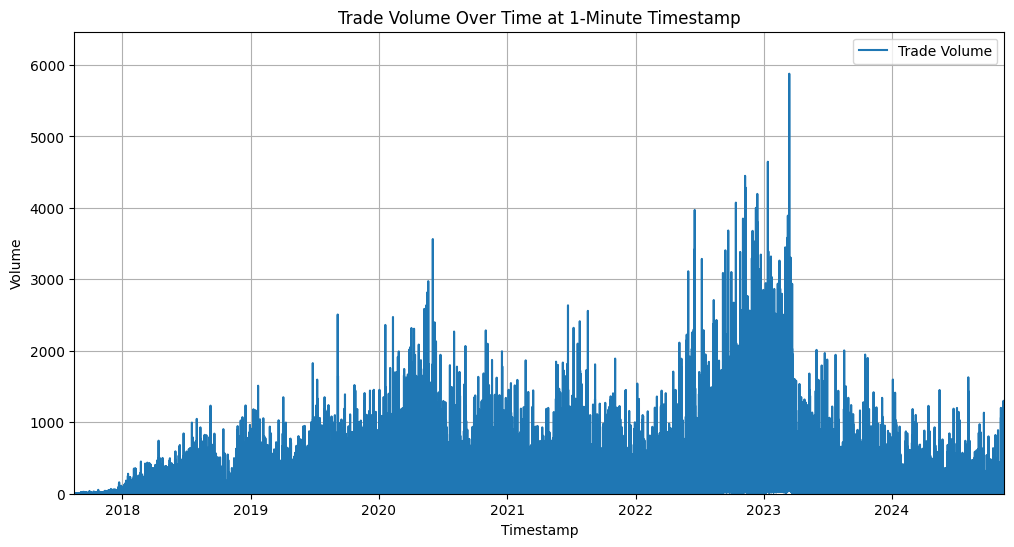

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(df_1m.index, df_1m['volume'], label='Trade Volume', linewidth=1.5)

plt.title('Trade Volume Over Time at 1-Minute Timestamp')
plt.xlabel('Timestamp')
plt.ylabel('Volume')
plt.xlim(df_1m.index.min(), df_1m.index.max())
plt.ylim(0, df_1m['volume'].max() * 1.1)
plt.grid(True)
plt.legend()
plt.show()

Same operations on the other two datasets.

In [18]:
# Compute lagged differences for the 1-hour and 1-day datasets
df_1h['open_diff'] = df_1h['open'].diff()
df_1h['high_diff'] = df_1h['high'].diff()
df_1h['low_diff'] = df_1h['low'].diff()
df_1h['close_diff'] = df_1h['close'].diff()
df_1h = df_1h.dropna()

df_1d['open_diff'] = df_1d['open'].diff()
df_1d['high_diff'] = df_1d['high'].diff()
df_1d['low_diff'] = df_1d['low'].diff()
df_1d['close_diff'] = df_1d['close'].diff()
df_1d = df_1d.dropna()

Lastly, I will check the unique values and their respective counts for the datasets.

In [19]:
unique_counts_1m_t_minus1 = df_1m['direction_t-1'].value_counts()
print(unique_counts_1m_t_minus1)

direction_t-1
 1    1857635
-1    1848887
 0     106484
Name: count, dtype: int64


In [20]:
unique_counts_1m_plus1 = df_1m['direction_t+1'].value_counts()
print(unique_counts_1m_plus1)

direction_t+1
 1    1857635
-1    1848887
 0     106484
Name: count, dtype: int64


In [21]:
unique_counts_1h_minus1 = df_1h['direction_t-1'].value_counts()
print(unique_counts_1h_minus1)

direction_t-1
 1    32439
-1    31082
 0       29
Name: count, dtype: int64


In [22]:
unique_counts_1h_plus1 = df_1h['direction_t+1'].value_counts()
print(unique_counts_1h_plus1)

direction_t+1
 1    32438
-1    31082
 0       30
Name: count, dtype: int64


In [23]:
unique_counts_1d_minus1 = df_1d['direction_t-1'].value_counts()
print(unique_counts_1d_minus1)

direction_t-1
 1    1364
-1    1284
Name: count, dtype: int64


In [24]:
unique_counts_1d_plus1 = df_1d['direction_t+1'].value_counts()
print(unique_counts_1d_plus1)

direction_t+1
 1    1364
-1    1283
 0       1
Name: count, dtype: int64


For the 1-hour dataset, we have very few cases with no-change (0) in direction. This may confuse the model during the training process. There, I will replace them with the next non-zero value to indicate the overall changing pattern for the 1-hour time interval.

In [25]:
# Replace zeros in a column with the next non-zero value
def replace_zeros_with_next_nonzero(direction_column):
    direction_list = direction_column.tolist()
    
    for i in range(len(direction_list) - 1):
        if direction_list[i] == 0:
            for j in range(i + 1, len(direction_list)):
                if direction_list[j] != 0:
                    direction_list[i] = direction_list[j]
                    break
    
    return pd.Series(direction_list, index=direction_column.index)

df_1h['direction_t-1'] = replace_zeros_with_next_nonzero(df_1h['direction_t-1'])
print(df_1h['direction_t-1'].value_counts())

direction_t-1
 1    32449
-1    31101
Name: count, dtype: int64


In [26]:
df_1h['direction_t+1'] = replace_zeros_with_next_nonzero(df_1h['direction_t+1'])
print(df_1h['direction_t+1'].value_counts())

direction_t+1
 1    32448
-1    31101
 0        1
Name: count, dtype: int64


Just checked the data, the last value of direction_t+1 is 0. It shall be removed.

In [27]:
df_1h = df_1h.iloc[:-1]
df_1d = df_1d.iloc[:-1]

Saving these new datasets.

In [28]:
df_1m.to_parquet('../data/03-lagged_differences_data/lagged_differences_data_1m.parquet', index=False)
df_1h.to_parquet('../data/03-lagged_differences_data/lagged_differences_data_1h.parquet', index=False)
df_1d.to_parquet('../data/03-lagged_differences_data/lagged_differences_data_1d.parquet', index=False)